# Basic Movie Recommendation System

## References 
https://www.geeksforgeeks.org/recommendation-system-in-python/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Loading data

### Ratings

In [2]:
ratings = pd.read_csv("./datasets/ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Movies

In [3]:
movies = pd.read_csv("./datasets/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## General Shapes Information

In [4]:
print(f"""
ratings dataframe shape :{ratings.shape}
movies dataframe shape  :{movies.shape}

total movies : {movies.movieId.unique().shape}
total rated movies : {ratings.movieId.unique().shape}

total users : {ratings.userId.unique().shape}
All kind of ratings given by users : {ratings.rating.unique()}""")


ratings dataframe shape :(100836, 4)
movies dataframe shape  :(9742, 3)

total movies : (9742,)
total rated movies : (9724,)

total users : (610,)
All kind of ratings given by users : [4.  5.  3.  2.  1.  4.5 3.5 2.5 0.5 1.5]


## Get unique ids

In [5]:
all_user_ids = ratings.userId.unique()
all_movie_ids = movies.movieId.unique()

## Creating Maps

In [6]:
from IPython.display import clear_output

### Map to convert user id to user mapping id

In [7]:
user_id_maps = { i[0]:i[1] for i in enumerate(all_user_ids) }

### Map to convert user mapping id to user id

In [8]:
user_id_inv_maps = { user_id_maps[i]:i for i in user_id_maps }

### Map to convert movie id to movie mapping id

In [9]:
movie_id_maps = { i[0]:i[1] for i in enumerate(all_movie_ids) }

### Map to convert movie mapping id to movie id

In [10]:
movie_id_inv_maps = { movie_id_maps[i]:i for i in movie_id_maps }

## user-movie average rating 

In [11]:
user_movie_ratings_df = ratings[['userId','movieId','rating']]\
                            .groupby(by=['userId', 'movieId'],as_index=False)\
                            .mean()

In [12]:
user_movie_ratings_df.columns

Index(['userId', 'movieId', 'rating'], dtype='object')

In [13]:
user_movie_ratings_df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


## Converting existing ids to mapping id

In [14]:
user_movie_ratings_df['user_maps'] = user_movie_ratings_df['userId'].apply(lambda x: user_id_inv_maps[x])
user_movie_ratings_df['movie_maps'] = user_movie_ratings_df['movieId'].apply(lambda x: movie_id_inv_maps[x])

In [15]:
user_movie_ratings_df.head()

,userId,movieId,rating,user_maps,movie_maps
0,1,1,4.0,0,0
1,1,3,4.0,0,2
2,1,6,4.0,0,5
3,1,47,5.0,0,43
4,1,50,5.0,0,46


## Creating User-Movie Rating Matrix

In [16]:
from scipy.sparse import csr_matrix

In [17]:
user_maps = user_movie_ratings_df.user_maps.values
movie_maps = user_movie_ratings_df.movie_maps.values
rating_values = user_movie_ratings_df.rating.values

rating_matrix = csr_matrix((rating_values, (movie_maps, user_maps))).toarray()

In [18]:
rating_matrix

array([[4. , 0. , 0. , ..., 2.5, 3. , 5. ],
       [0. , 0. , 0. , ..., 2. , 0. , 0. ],
       [4. , 0. , 0. , ..., 2. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

So How is this working actually
```         
    user_maps = [0 1 2 3 4 5 6 7 8 9 10]
    movie_maps = [0 1 2 3 4 5 6 7 8 9 10]
    ratings = [3 4 1 5 5 2 5 1 1 4]
    
                                Users maps
                        
                         0  1  2  3  4  5  6  7  8  9  10
                         _  _  _  _  _  _  _  _  _  _  _ 
                      0 |3  0  0  0  0  0  0  0 
                      1 |0  4  0  0  0  0  0 
          movies maps 2 |0  0  1  0  0  0  .
                      3 |0  0  0  5  0  0  .        
                      4 |0  0  0  0  5  0  .
                      5 |0  0  0  0  0  2 
                      6 |0  0  0  0  0  0  
                      7 |.  .  .  .  
                      8 |.  . 
```

In [19]:
rating_matrix.shape

(9742, 610)

## Clustering Model 

In [20]:
from sklearn.neighbors import NearestNeighbors

In [21]:
n_neighbors = 10
metric = 'cosine'
kNN = NearestNeighbors(n_neighbors= n_neighbors, algorithm='brute', metric=metric)
kNN.fit(rating_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=10)

## Testing Model

In [22]:
movie_id = 1
movies.query(f'movieId == {movie_id}')

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [23]:
input_movie_vector = rating_matrix[movie_id_inv_maps[movie_id]].reshape(1,-1)
print("Input Movie Vector:",input_movie_vector.shape)

distances, collected_neighbours = kNN.kneighbors(
    X=input_movie_vector, n_neighbors=n_neighbors, return_distance=True)

iter_map = map(lambda x: movie_id_maps[x], collected_neighbours[0])

recoms = movies[movies.movieId.isin(iter_map)].reset_index()

recoms['distances'] = distances[0]

print("\nRecommendations :")
recoms.head(n_neighbors)

Input Movie Vector: (1, 610)

Recommendations :


,index,movieId,title,genres,distances
0,0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.330669e-16
1,224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.273987e-01
2,314,356,Forrest Gump (1994),Comedy|Drama|Romance|War,4.343632e-01
3,322,364,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX,4.357383e-01
4,418,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,4.426118e-01
5,546,648,Mission: Impossible (1996),Action|Adventure|Mystery|Thriller,4.529041e-01
6,615,780,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller,4.588547e-01
7,911,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,4.589107e-01
8,964,1265,Groundhog Day (1993),Comedy|Fantasy|Romance,4.610872e-01
9,2355,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,4.658312e-01


## Plotting distances

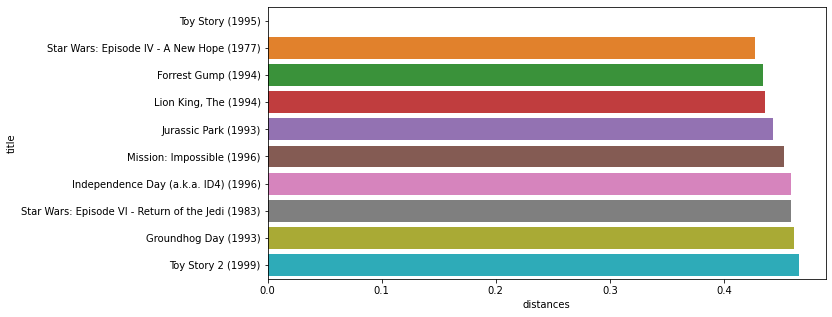

In [24]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.barplot(data=recoms, y='title', x='distances', orient='h')
plt.show()

## Recommendation System Modelling Class

In [25]:
from utils.engine import BasicMovieRecommedation

     movieId                     title          genres
196      230  Dolores Claiborne (1995)  Drama|Thriller


<AxesSubplot:ylabel='title'>

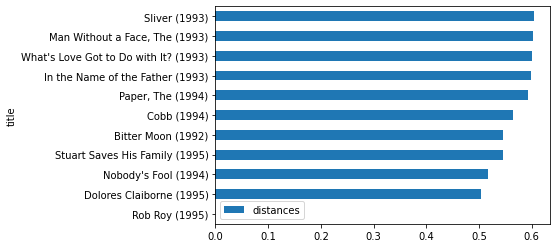

In [28]:
model = BasicMovieRecommedation(n_recomms=10)
model.fit(rating_df=ratings[['userId','movieId','rating']], movie_df=movies[['movieId']])

movie_input = 230
print(movies[movies.movieId.isin([movie_input])])
movie_ids, distances = model.get_recommendations(movie_input)

recoms = movies[movies.movieId.isin(movie_ids)].reset_index()
recoms['distances'] = distances

recoms.plot(x='title',y='distances',kind='barh')

In [29]:
recoms

,index,movieId,title,genres,distances
0,124,151,Rob Roy (1995),Action|Drama|Romance|War,0.000000
1,196,230,Dolores Claiborne (1995),Drama|Thriller,0.503135
2,243,281,Nobody's Fool (1994),Comedy|Drama|Romance,0.517969
3,271,312,Stuart Saves His Family (1995),Comedy,0.544872
4,305,347,Bitter Moon (1992),Drama|Film-Noir|Romance,0.546112
5,312,354,Cobb (1994),Drama,0.564007
6,329,371,"Paper, The (1994)",Comedy|Drama,0.593686
7,413,475,In the Name of the Father (1993),Drama,0.599766
8,415,477,What's Love Got to Do with It? (1993),Drama|Musical,0.600673
9,428,491,"Man Without a Face, The (1993)",Drama,0.602815
